Code done by;        Aswathi Ajith

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml

import math
from pennylane.optimize import AdamOptimizer

In [2]:
print("new testing")

new testing


In [ ]:
import numpy as np

# Variables for the PDE
num_variables = int(input("Enter the number of variables for the PDE: "))
all_variable_orders = []
all_variable_coefficients = []
variable_names = []
variable_indices = []
variable_values = {}

# vraible names, their order of differentiation, and coefficients of those variables's derivatives
for i in range(num_variables):
    variable_name = input(f"Enter the name for variable {i + 1}: ")
    variable_names.append(variable_name)
    variable_indices.append(i)
    num_orders = int(input(f"Enter the number of derivatives for variable {variable_name}: "))
    orders = []
    coefficients = []

    print(f"Variable: {variable_name}")
    for j in range(num_orders):
        order = int(input(f"Enter the order for derivative {j + 1} with respect to {variable_name}: "))
        coefficient = input(f"Enter the coefficient for derivative {j + 1} with respect to {variable_name} (as a function of {variable_name}): ")
        orders.append(order)
        coefficients.append(coefficient)

    # To get the range values of variables
    low_value = float(input(f"Enter the low value for variable {variable_name}: "))
    high_value = float(input(f"Enter the high value for variable {variable_name}: "))
    # Discretizing the range with certain step size value
    step_size = float(input(f"Enter the step size for generating random numbers for variable {variable_name}: "))

    random_values = np.linspace(low_value, high_value, int((high_value - low_value) / step_size) + 1)
    print(f"Values for {variable_name}:")
    for value in random_values:
        print(value)

    all_variable_orders.append(orders)
    all_variable_coefficients.append(coefficients)
    variable_values[variable_name] = random_values.tolist()  

# Collect terms that are not derivatives in the PDE(e.g., u**2, sin(u), u, etc....)
non_derivative_terms = []
add_non_derivative_terms = input("Are there any non-derivative terms? type (yes/no): ").strip().lower()

while add_non_derivative_terms == "yes":
    term = input("Enter the non-derivative term : ")
    non_derivative_terms.append(term)
    add_non_derivative_terms = input("Is there any more non-derivative terms? (yes/no): ").strip().lower()

# To print all info;
print("Variable Names:", variable_names)
print("Variable Values:", variable_values)
print("Variable Orders:", all_variable_orders)
print("Variable Coefficients:", all_variable_coefficients)
print("Non-Derivative Terms:", non_derivative_terms)

# To construct the PDE expression
def construct_pde_expression(variable_names, all_variable_orders, all_variable_coefficients, non_derivative_terms):
    pde_expression = ""
    
    for i, (variable_name, orders, coefficients) in enumerate(zip(variable_names, all_variable_orders, all_variable_coefficients)):
        for order, coeff in zip(orders, coefficients):
            if "lambda" in coeff:  
                term = f"{coeff}*d^{order}u/d{variable_name}^{order}"
            else:
                term = f"{coeff}*d^{order}u/d{variable_name}^{order}"
            pde_expression += term + " + "

    
    for term in non_derivative_terms:
        pde_expression += term + " + "
    pde_expression = pde_expression[:-3] 
    return pde_expression


pde_expression = construct_pde_expression(variable_names, all_variable_orders, all_variable_coefficients, non_derivative_terms)
print("Constructed PDE:", pde_expression)




In [ ]:
#Check
variable_data = [(key, values) for key, values in variable_values.items()]
for variable, values in variable_data:
    print(f"{variable} = {values}",len(values))

In [ ]:


cost_array =[]

chosen_variables = input("Enter the names of the variables to encode (comma-separated): ").split(',')
chosen_variables = [v.strip() for v in chosen_variables]


variable_dict = dict(variable_data)
for var in chosen_variables:
    if var not in variable_dict:
        raise ValueError(f"Variable '{var}' is not in the list of available variables.")


selected_values = [variable_dict[var] for var in chosen_variables]
selected_values = np.array(selected_values)
print(f"Selected values:\n{selected_values}")


num_qubits = len(chosen_variables)


dev = qml.device("default.qubit", wires=num_qubits)

# variational circuit
@qml.qnode(dev)
def variational_circuit(params, num_layers, variable_values):
    # Feature maps
    for i, value in enumerate(variable_values):
        qml.RY(2 * np.arccos(np.clip(value, -1, 1)), wires=i)

    # Parametrized variational circuits
    for layer in range(num_layers):
        for i in range(len(variable_values)):
            qml.RZ(params[layer, i, 0], wires=i)
            qml.RX(params[layer, i, 1], wires=i)
            # ansatz reduced --------------------
            
        for i in range(len(variable_values) - 1):
            qml.CNOT(wires=[i, i + 1])

    return [qml.expval(qml.PauliZ(i)) for i in range(len(variable_values))]

#  cost function
def cost_fn(params, num_layers, variable_data, chosen_variables):
    total_cost = 0
    num_iterations = len(variable_data[0][1])
  
    
    for i in range(num_iterations):
        selected_values = [variable_data[var_idx][1][i] for var_idx, var in enumerate(variable_data) if var[0] in chosen_variables]
        outputs = variational_circuit(params, num_layers, selected_values)
        
        cost = np.sum(outputs) #sigma(j)
        total_cost += cost #sigma(cost)
        print(f"Iteration {i+1}:")
        print(f"Variable Names: {chosen_variables}")
        print(f"Variable Values: {selected_values}")
        print(f"Cost: {cost}")
        print("outputs are",outputs)
        cost_array.append(cost)
    
    return total_cost,cost_array

# number of layers
num_layers = 6

# Initialize the parameters
np.random.seed(42)

params = np.random.uniform(-2*np.pi, 2*np.pi, size=(num_layers, num_qubits, 3))


# Calculate the cost
total_cost, cost_array = cost_fn(params, num_layers, variable_data, chosen_variables)


print(f"Total cost = {total_cost}")
print(f"The cost array is = {cost_array}")




In [15]:


def compute_derivatives_for_variables(cost_fn, variable_names, variable_data, chosen_variables, shift, num_layers, params):
    derivatives = []
    variable_dict = dict(variable_data)
    
    for variable_to_differentiate in variable_names:
        num_orders = int(input(f"Enter the number of orders for {variable_to_differentiate}: "))
        if num_orders <= 0:
            print("Number of orders must be positive.")
            continue

        for j in range(1, num_orders + 1):
            variable_values_plus = {var: variable_dict[var][:] for var in variable_dict}
            variable_values_minus = {var: variable_dict[var][:] for var in variable_dict}

         
            for _ in range(j):
                variable_values_plus[variable_to_differentiate] = [a + shift for a in variable_values_plus[variable_to_differentiate]]
                variable_values_minus[variable_to_differentiate] = [a - shift for a in variable_values_minus[variable_to_differentiate]]

          
            variable_data_plus = [(var, variable_values_plus[var]) for var in variable_dict]
            variable_data_minus = [(var, variable_values_minus[var]) for var in variable_dict]
            

          
            output_plus, _ = cost_fn(params, num_layers, variable_data_plus, chosen_variables)
            output_minus, _ = cost_fn(params, num_layers, variable_data_minus, chosen_variables)
            # print(output_minus)
            # print(output_plus)

     
            derivative = (output_plus - output_minus) / (2)
            derivatives.append((variable_to_differentiate, j, derivative))

    return derivatives


shift = 0.01  
derivatives = compute_derivatives_for_variables(cost_fn, chosen_variables, variable_data, chosen_variables, shift, num_layers, params)
print(derivatives)

In [14]:
# To calculate the PDE value from the fucntion and the derivative values 

def calculate_PDE_from_derivatives(derivatives, variable_names, total_cost):
    print("Derivatives:")
    for derivative in derivatives:
        print(f"Variable: {derivative[0]}, Order: {derivative[1]}, Value: {derivative[2]}")
    
    # To get the number of derivative and non-derivative terms in the PDE expression
    num_derivative_terms = int(input("Enter the number of derivative terms in the PDE: "))
    num_non_derivative_terms = int(input("Enter the number of non-derivative terms in the PDE: "))
    
    PDE_value = 0
    # To get the details of the derivative terms
    for _ in range(num_derivative_terms):
        variable = input(f"Enter variable for the derivative term from the list {variable_names}: ")
        order = int(input(f"Enter the order of the derivative for {variable}: "))
        coefficient_input = input(f"Enter the coefficient for the derivative term with {variable} of order {order} (can be a variable, 'total_cost', or numerical value): ")
        
        # To check if the coefficient of the derivative is the mutliplied by fucntion value(as in non linear PDE) or just a numerical value
        if coefficient_input in variable_names:
            coefficient = float(input(f"Enter value for the variable {coefficient_input}: "))
            
        elif coefficient_input == 'total_cost':
            coefficient = total_cost
        else:
            coefficient = float(coefficient_input)
        selected_derivative = None
        for derivative in derivatives:
            if derivative[0] == variable and derivative[1] == order:
                selected_derivative = derivative[2]
                break
        if selected_derivative is not None:
            PDE_value += coefficient * selected_derivative
        else:
            return f"Derivative value not found for variable {variable} with order {order}."
    
    # To get the non derivative terms in the PDE 

    for _ in range(num_non_derivative_terms):
        coefficient_input = input("Enter the coefficient for the non-derivative term : ") # this can also be a numerical coefficient or the fucntion value itslef
        
        if coefficient_input in variable_names:
            coefficient = float(input(f"Enter value for the variable {coefficient_input}: "))
        elif coefficient_input == 'total_cost':
            coefficient = total_cost
        else:
            coefficient = float(coefficient_input)
        
        non_derivative_expr = input("Enter the expression for the non-derivative term : ")
        variable_used = input("Which variable is used in the expression? Enter the variable name or 'total_cost': ")
        
        variable_values = {var: 0 for var in variable_names}
        if variable_used in variable_names:
            variable_values[variable_used] = float(input(f"Enter value for the variable {variable_used}: "))
        elif variable_used == 'total_cost':
            variable_values['total_cost'] = total_cost
        
        non_derivative_value = eval(non_derivative_expr, {"__builtins__": None}, variable_values)
        PDE_value += coefficient * non_derivative_value
    
    return PDE_value

# Final PDE value
PDE_value = calculate_PDE_from_derivatives(derivatives, variable_names, total_cost)
print(f"PDE value: {PDE_value}")


Derivatives:
Variable: t, Order: 1, Value: 0.0
Variable: t, Order: 2, Value: 0.0
Variable: x, Order: 1, Value: -40.64954000193177
Variable: x, Order: 2, Value: 0.0
Variable: y, Order: 1, Value: -40.64954000193177
Variable: y, Order: 2, Value: 0.0
Variable: z, Order: 1, Value: -40.64954000193177
Variable: z, Order: 2, Value: 0.0


ValueError: invalid literal for int() with base 10: ''

In [ ]:

global initial_condition_values, boundary_condition_values
initial_condition_values = None
boundary_condition_values = None

# To get the initial condition
def handle_initial_condition():
    global initial_condition_values
    print("List of variables:", variable_names)
    variables_in_condition = input("Enter the variables involved in the initial condition separated by commas: ").split(',')
    
    valid_variables = [var.strip() for var in variables_in_condition if var.strip() in variable_names]
    
    if len(valid_variables) == len(variables_in_condition):
        initial_condition_expr = input("Enter the initial condition expression at t=0: ")
        
        variable_values_combinations = [variable_values[var] for var in valid_variables]
        
        try:
            print("Initial Condition Expression:", initial_condition_expr)
            
            initial_condition_values = []
            for values in zip(*variable_values_combinations):
                eval_context = {var: val for var, val in zip(valid_variables, values)}
                eval_context.update({'np': np, 'math': math})
                initial_condition = eval(initial_condition_expr, eval_context)
                initial_condition_values.append(initial_condition)
            
            initial_condition_values = np.array(initial_condition_values)
            return initial_condition_values
        
        except Exception as e:
            print("Invalid expression. Please enter a valid mathematical expression.")
            print(e)
            return None
    else:
        print("Invalid variable selection. Please choose variables from the provided list.")
        return None

# To get the boundary condition
def handle_boundary_conditions():
    global boundary_condition_values
    boundary_condition_values = {}
    
    num_boundary_variables = int(input("Enter the number of variables involved in the boundary condition: "))
    
    if num_boundary_variables == 0:
        boundary_condition_expr = input("Enter the boundary condition value: ")
        boundary_condition_values = float(boundary_condition_expr)
        return boundary_condition_values
    
    variables_in_condition = []
    
    for _ in range(num_boundary_variables):
        variable_name = input(f"Enter the variable name for the boundary condition (from the list {variable_names}): ")
        if variable_name in variable_values:
            variables_in_condition.append(variable_name)
        else:
            print("Invalid variable selection. Please select a variable from the list of variables.")
            return None
    
    boundary_condition_expr = input("Enter the boundary condition expression: ")
    
    for variable_name in variables_in_condition:
        boundary_values = variable_values[variable_name]
        lowest_value = boundary_values[0]
        highest_value = boundary_values[-1]
        
        print(f"Values for variable {variable_name}: ")
        for value in boundary_values:
            print(value)
        
        boundary_type = input(f"Enter the boundary type for {variable_name} (point/range): ")
        
        if boundary_type == 'point':
            boundary_value = lowest_value
        elif boundary_type == 'range':
            lower_boundary_start = float(input(f"Enter the starting value for the lower boundary condition (between {lowest_value} and {highest_value}): "))
            lower_boundary_end = float(input(f"Enter the ending value for the lower boundary condition (between {lowest_value} and {highest_value}): "))
            upper_boundary_start = float(input(f"Enter the starting value for the upper boundary condition (between {lowest_value} and {highest_value}): "))
            upper_boundary_end = float(input(f"Enter the ending value for the upper boundary condition (between {lowest_value} and {highest_value}): "))
        else:
            print("Invalid boundary type. Please enter 'point' or 'range'.")
            return None
        
        try:
            print("Boundary Condition Expression:", boundary_condition_expr)
            print(f"Boundary Variable: {variable_name}")
            
            if boundary_type == 'point':
                print(f"Boundary Value: {boundary_value}")
                boundary_condition_values[variable_name] = boundary_value
            elif boundary_type == 'range':
                print(f"Lower Boundary Range: [{lower_boundary_start}, {lower_boundary_end}]")
                print(f"Upper Boundary Range: [{upper_boundary_start}, {upper_boundary_end}]")
                
                lower_boundary_values = [value for value in boundary_values if lower_boundary_start <= value <= lower_boundary_end]
                upper_boundary_values = [value for value in boundary_values if upper_boundary_start <= value <= upper_boundary_end]
                
                lower_boundary_function_values = [eval(boundary_condition_expr, {variable_name: value, 'np': np, 'math': math}) for value in lower_boundary_values]
                upper_boundary_function_values = [eval(boundary_condition_expr, {variable_name: value, 'np': np, 'math': math}) for value in upper_boundary_values]
                
                boundary_condition_values[variable_name] = {
                    'lower_boundary_start': lower_boundary_start,
                    'lower_boundary_end': lower_boundary_end,
                    'lower_boundary_values': lower_boundary_values,
                    'lower_boundary_function_values': lower_boundary_function_values,
                    'upper_boundary_start': upper_boundary_start,
                    'upper_boundary_end': upper_boundary_end,
                    'upper_boundary_values': upper_boundary_values,
                    'upper_boundary_function_values': upper_boundary_function_values
                }
                
                print(f"Lower Boundary Function Values for {variable_name}: {lower_boundary_function_values}")
                print(f"Upper Boundary Function Values for {variable_name}: {upper_boundary_function_values}")
            
        except Exception as e:
            print("Invalid expression. Please enter a valid mathematical expression.")
            print(e)
    
    return boundary_condition_values

# Function call
condition_type = input("Enter the problem type (initial/boundary/both): ")

if condition_type == 'initial':
    handle_initial_condition()
    print("Initial Condition Values:", initial_condition_values)
elif condition_type == 'boundary':
    boundary_condition_values = handle_boundary_conditions()
    print("Boundary Condition Values:", boundary_condition_values)
elif condition_type == 'both':
    handle_initial_condition()
    boundary_condition_values = handle_boundary_conditions()
    print("Initial Condition Values:", initial_condition_values)
    print("Boundary Condition Values:", boundary_condition_values)
else:
    print("Invalid input. Please enter 'initial' for an initial value problem, 'boundary' for a boundary value problem, or 'both' for both initial and boundary conditions.")


List of variables: ['t', 'x']
Initial Condition Expression: -np.sin(3.14*x)
Initial Condition Values: [ 0.00159265  0.00787257  0.01415218 ... -0.01415218 -0.00787257
 -0.00159265]
Boundary Condition Values: 0.0


In [ ]:
boundary_condition_values


0.0

In [ ]:
def cost_fn_bc(params, num_layers, variable_values, variable_names):
    bc_loss_values = []
    for var in variable_names:
        var_index = variable_names.index(var)
        var_min = variable_values[var_index][0]
        var_max = variable_values[var_index][-1]
        
        # Run the variational circuit for the minimum and maximum values of the variable
        min_values = [0.0] * len(variable_values)
        min_values[var_index] = var_min
        min_outputs = variational_circuit(params, num_layers, np.array(min_values))
        
        max_values = [0.0] * len(variable_values)
        max_values[var_index] = var_max
        max_outputs = variational_circuit(params, num_layers, np.array(max_values))
        
        # Calculate the loss for the minimum and maximum values of the variable
        bc_loss_values.append((min_outputs[0] - var_min) ** 2)
        bc_loss_values.append((max_outputs[0] - var_max) ** 2)
    
    return bc_loss_values



bc_loss_values = cost_fn_bc(params, num_layers, variable_values, variable_names)
print(bc_loss_values)

KeyError: 0

In [ ]:
initial_condition_values

array([ 0.00159265,  0.00787257,  0.01415218, ..., -0.01415218,
       -0.00787257, -0.00159265])

In [ ]:
np.sin(3.14*x)*np.sin(3.14*y)*np.sin(3.14*z)

In [ ]:
def cost_fn_ic(params, num_layers, variable_values):
    ic_loss_values = []
    for values in variable_values:
        selected_values = np.append(values, 0.0)  # t=0 for the initial condition
        clipped_values = np.clip(selected_values.astype(float), -1, 1)
        outputs = variational_circuit(params, num_layers, clipped_values)
        ic_loss_values.append((outputs[0] - initial_condition_values[0]) ** 2)
    return ic_loss_values
for key in variable_values:
    variable_values[key] = [float(value) for value in variable_values[key]]
variable_values_list = list(zip(*[variable_values[key] for key in variable_values.keys()]))
ic_loss_values = cost_fn_ic(params, num_layers, variable_values_list)
print (np.mean(ic_loss_values))

0.10297242682980556


In [ ]:
print("Loss from initial condition =", (np.mean(ic_loss_values)))


Loss from initial condition = 0.10297242682980556


In [ ]:
PDE_value

2.6794169049008608e-14

In [ ]:
ic_loss = np.mean(ic_loss_values)
print(ic_loss)

0.10297242682980556


In [ ]:
7.1792749502685085e-28 + (1.0*0.02934235880793538)

0.02934235880793538

In [ ]:
pde_loss = ((PDE_value - 0) ** 2)
print('Loss from PDE calculated',pde_loss)

Loss from PDE calculated 7.072778479433872e-22


In [ ]:
#Check
variable_data = [(key, values) for key, values in variable_values.items()]

for variable, values in variable_data:
    print(f"{variable} = {values}")



t = [0.0, 0.0001, 0.0002, 0.00030000000000000003, 0.0004, 0.0005, 0.0006000000000000001, 0.0007, 0.0008, 0.0009000000000000001, 0.001, 0.0011, 0.0012000000000000001, 0.0013000000000000002, 0.0014, 0.0015, 0.0016, 0.0017000000000000001, 0.0018000000000000002, 0.0019, 0.002, 0.0021000000000000003, 0.0022, 0.0023, 0.0024000000000000002, 0.0025, 0.0026000000000000003, 0.0027, 0.0028, 0.0029000000000000002, 0.003, 0.0031000000000000003, 0.0032, 0.0033, 0.0034000000000000002, 0.0035, 0.0036000000000000003, 0.0037, 0.0038, 0.0039000000000000003, 0.004, 0.0041, 0.004200000000000001, 0.0043, 0.0044, 0.0045000000000000005, 0.0046, 0.0047, 0.0048000000000000004, 0.0049, 0.005, 0.0051, 0.005200000000000001, 0.0053, 0.0054, 0.0055000000000000005, 0.0056, 0.0057, 0.0058000000000000005, 0.0059, 0.006, 0.0061, 0.006200000000000001, 0.0063, 0.0064, 0.006500000000000001, 0.0066, 0.0067, 0.0068000000000000005, 0.006900000000000001, 0.007, 0.0071, 0.007200000000000001, 0.0073, 0.0074, 0.007500000000000001

In [ ]:
second_key, second_values = variable_data[1]

print(f"Second Key: {second_key}")
print(f"Second Values: {second_values}")

Second Key: x
Second Values: [0.0, 0.02040816326530612, 0.04081632653061224, 0.061224489795918366, 0.08163265306122448, 0.1020408163265306, 0.12244897959183673, 0.14285714285714285, 0.16326530612244897, 0.18367346938775508, 0.2040816326530612, 0.22448979591836732, 0.24489795918367346, 0.26530612244897955, 0.2857142857142857, 0.3061224489795918, 0.32653061224489793, 0.3469387755102041, 0.36734693877551017, 0.3877551020408163, 0.4081632653061224, 0.42857142857142855, 0.44897959183673464, 0.4693877551020408, 0.4897959183673469, 0.5102040816326531, 0.5306122448979591, 0.5510204081632653, 0.5714285714285714, 0.5918367346938775, 0.6122448979591836, 0.6326530612244897, 0.6530612244897959, 0.673469387755102, 0.6938775510204082, 0.7142857142857142, 0.7346938775510203, 0.7551020408163265, 0.7755102040816326, 0.7959183673469387, 0.8163265306122448, 0.836734693877551, 0.8571428571428571, 0.8775510204081632, 0.8979591836734693, 0.9183673469387754, 0.9387755102040816, 0.9591836734693877, 0.979591836

In [ ]:
def calculate_loss(PDE_value, ic_loss, bc_loss, ic_weight=1.0, bc_weight=1.0):
    pde_loss = np.mean((PDE_value - 0) ** 2)

    condition_type = input("Enter whether the problem is initial, boundary or both: ").strip().lower()

    if condition_type == 'initial':
        total_loss = pde_loss + ic_weight * np.mean([np.mean(value) for value in ic_loss.values()])
    elif condition_type == 'boundary':
        total_loss = pde_loss + bc_weight * bc_loss
    else:

        total_loss = pde_loss + ic_weight * np.mean(ic_loss) + bc_weight * bc_loss

    return total_loss

ic_loss = np.mean(ic_loss_values)
bc_loss = 0

total_loss = calculate_loss(PDE_value, ic_loss, bc_loss, ic_weight=1.0, bc_weight=1.0)
print('Total loss is', total_loss)




Total loss is 0.10297242682980556


Derivatives:
Variable: t, Order: 1, Value: -4.638893657032501e-14
Variable: t, Order: 2, Value: -1.4773546678447454e-14
Variable: x, Order: 1, Value: -4.638893657032501e-14
Variable: x, Order: 2, Value: -1.4773546678447454e-14
Iteration 1, Loss: 0.10297242682980556, Parameter: 0.11782064759981957
Derivatives:
Variable: t, Order: 1, Value: -4.638893657032501e-14
Variable: t, Order: 2, Value: -1.4773546678447454e-14
Variable: x, Order: 1, Value: -4.638893657032501e-14
Variable: x, Order: 2, Value: -1.4773546678447454e-14
Iteration 2, Loss: 0.10283426603087094, Parameter: 0.11679230494004275
Derivatives:
Variable: t, Order: 1, Value: -4.638893657032501e-14
Variable: t, Order: 2, Value: -1.4773546678447454e-14
Variable: x, Order: 1, Value: -4.638893657032501e-14
Variable: x, Order: 2, Value: -1.4773546678447454e-14
Iteration 3, Loss: 0.10269495587555103, Parameter: 0.11576535538181913
Derivatives:
Variable: t, Order: 1, Value: -4.638893657032501e-14
Variable: t, Order: 2, Value: -1.4773546

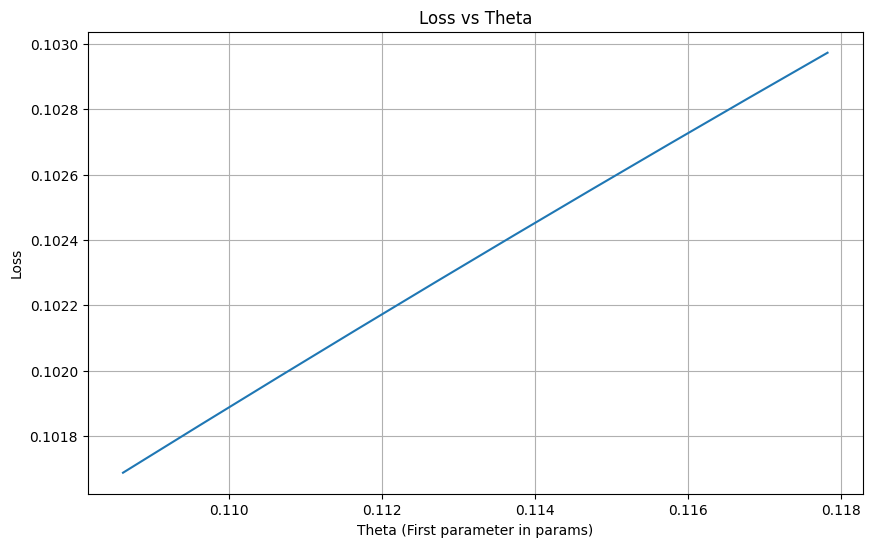

In [ ]:

alpha = 0.01
ic_weight = 1
bc_weight = 1
loss_values = []
param_values = [] 
num_iterations = 10

# gradient descent
for n in range(num_iterations):
    # Calculate the loss
    ic_loss_values = cost_fn_ic(params, num_layers, variable_values_list)
    ic_loss = np.mean(ic_loss_values)
    bc_loss = 0  # Assuming bc_loss is zero 
    
    loss = calculate_loss(PDE_value, ic_loss, bc_loss, ic_weight, bc_weight)

    # Calculating  the gradient of the loss with respect to the parameter
    gradient = ic_weight * ic_loss - 2 * (PDE_value - 0)  

    # Updating the parameters
    params = params - alpha * gradient 

    # Recalculate PDE value
    PDE_value = calculate_PDE_from_derivatives(derivatives, variable_names, total_cost)
    loss_values.append(loss)
    param_values.append(params.flatten()[0])  
    print(f"Iteration {n+1}, Loss: {loss}, Parameter: {params.flatten()[0]}")

# Plot Loss vs Iteration number
plt.figure(figsize=(10, 6))
plt.plot(param_values, loss_values)
plt.xlabel('Theta (First parameter in params)')
plt.ylabel('Loss')
plt.title('Loss vs Theta')
plt.grid(True)
plt.show()

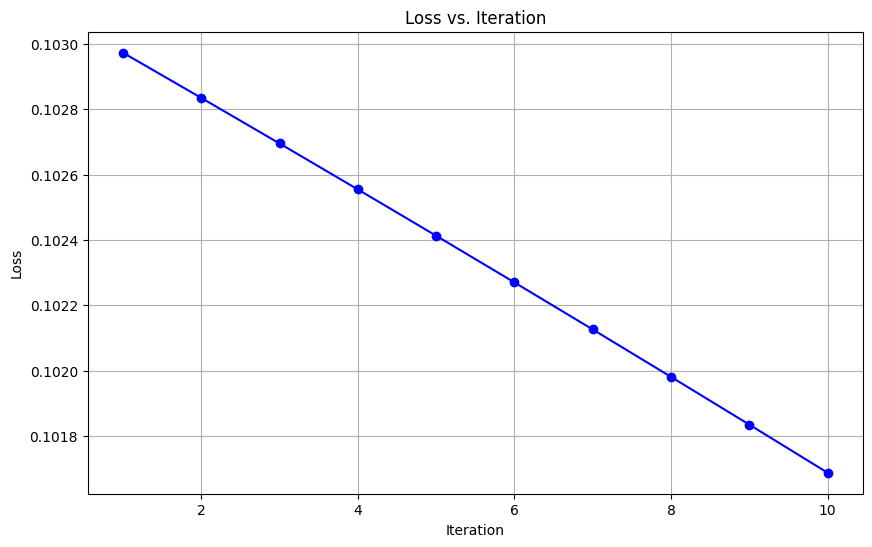

In [ ]:
import matplotlib.pyplot as plt

# Provided data
data = """
Iteration 1, Loss: 0.10297242682980556, Parameter: 0.11782064759981957
Iteration 2, Loss: 0.10283426603087094, Parameter: 0.11679230494004275
Iteration 3, Loss: 0.10269495587555103, Parameter: 0.11576535538181913
Iteration 4, Loss: 0.10255450541135401, Parameter: 0.11473981032823749
Iteration 5, Loss: 0.10241292382083435, Parameter: 0.11371568109056104
Iteration 6, Loss: 0.10227022041899046, Parameter: 0.11269297888690304
Iteration 7, Loss: 0.10212640465062953, Parameter: 0.11167171484092864
Iteration 8, Loss: 0.10198148608770044, Parameter: 0.11065189998058353
Iteration 9, Loss: 0.10183547442659606, Parameter: 0.10963354523684947
Iteration 10, Loss: 0.1016883794854276, Parameter: 0.10861666144252709
"""

# Parse the data
iterations = []
loss_values = []

for line in data.strip().split("\n"):
    parts = line.split(", ")
    iteration = int(parts[0].split()[1])
    loss = float(parts[1].split()[1])
    iterations.append(iteration)
    loss_values.append(loss)

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(iterations, loss_values, marker='o', linestyle='-', color='b')
plt.title('Loss vs. Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [ ]:
0.10861666144252709

In [ ]:



num_qubits = 6
dev = qml.device("default.qubit", wires=num_qubits)
@qml.qnode(dev)
def variational_circuit1(params, num_layers, variable_values):

    # feature maps
    for i, value in enumerate(variable_values):
        qml.RY(2 * np.arccos(np.clip(value, -1, 1)), wires=i)

    # paramterized variational circuits
    for layer in range(num_layers):
        for i in range(len(variable_values)):
            qml.RZ(params[layer, i, 0], wires=i)
            qml.RX(params[layer, i, 1], wires=i)
        for i in range(len(variable_values) - 1):
            qml.CNOT(wires=[i, i + 1])

    
    return [qml.expval(qml.PauliZ(i)) for i in range(len(variable_values))]
global fn_values        
# Function to calculate the cost fucntion
def cost_fn1(params, num_layers, variable_values):
    fn_values =[] 
    total_cost = 0
    num_iterations = variable_values.shape[1] if len(variable_values.shape) > 1 else variable_values.shape[0]
    for i in range(num_iterations):
        selected_values = variable_values[:, i] if len(variable_values.shape) > 1 else variable_values
        outputs = variational_circuit1(params, num_layers, selected_values)
        fn_values.append(outputs)
        print(outputs,'      ',selected_values)
        cost = np.sum(outputs)
        total_cost += cost
    return fn_values

num_layers = 4
params = np.full((num_layers, num_qubits, 2), 0.10861666144252709)

# To choose variables to encode
chosen_variables = input(f"Choose the variables to encode from the list {variable_names} (comma-separated): ")
chosen_variables = [v.strip() for v in chosen_variables.split(',')]
selected_values = np.concatenate([variable_values[v] for v in chosen_variables], axis=0)

# To reshape
selected_values = selected_values.reshape(1, -1)
total_cost1 = cost_fn1(params, num_layers, selected_values)
print(f"Total cost = {total_cost1}")
# print(params)


[tensor(0.90846017, requires_grad=True)]        [-1.]
[tensor(0.88689037, requires_grad=True)]        [-0.998]
[tensor(0.87376801, requires_grad=True)]        [-0.996]
[tensor(0.862062, requires_grad=True)]        [-0.994]
[tensor(0.85110175, requires_grad=True)]        [-0.992]
[tensor(0.84062678, requires_grad=True)]        [-0.99]
[tensor(0.83050316, requires_grad=True)]        [-0.988]
[tensor(0.82065114, requires_grad=True)]        [-0.986]
[tensor(0.81101859, requires_grad=True)]        [-0.984]
[tensor(0.80156924, requires_grad=True)]        [-0.982]
[tensor(0.7922766, requires_grad=True)]        [-0.98]
[tensor(0.78312062, requires_grad=True)]        [-0.978]
[tensor(0.77408568, requires_grad=True)]        [-0.976]
[tensor(0.76515935, requires_grad=True)]        [-0.974]
[tensor(0.7563315, requires_grad=True)]        [-0.972]
[tensor(0.74759377, requires_grad=True)]        [-0.97]
[tensor(0.73893916, requires_grad=True)]        [-0.968]
[tensor(0.73036173, requires_grad=True)] 

In [ ]:
extracted_values = [value[0].item() for value in total_cost1]

# Print extracted values
for i, value in enumerate(extracted_values):
    print(f"Value {i+1}: {value}")

Value 1: 0.9084601739202316
Value 2: 0.8868903666041597
Value 3: 0.8737680081724576
Value 4: 0.8620620015379343
Value 5: 0.8511017458050737
Value 6: 0.8406267772258806
Value 7: 0.8305031633060763
Value 8: 0.8206511363957233
Value 9: 0.8110185901739627
Value 10: 0.8015692390220326
Value 11: 0.7922765962681697
Value 12: 0.7831206157117535
Value 13: 0.7740856838220107
Value 14: 0.765159352387455
Value 15: 0.7563315027634337
Value 16: 0.7475937745082537
Value 17: 0.7389391627799855
Value 18: 0.7303617272525244
Value 19: 0.721856376940048
Value 20: 0.71341870803099
Value 21: 0.7050448795783057
Value 22: 0.696731516763236
Value 23: 0.6884756345980237
Value 24: 0.6802745770185292
Value 25: 0.6721259677296457
Value 26: 0.6640276701412977
Value 27: 0.6559777544179635
Value 28: 0.6479744701539526
Value 29: 0.640016223541314
Value 30: 0.6321015581577031
Value 31: 0.6242291386952579
Value 32: 0.6163977370972223
Value 33: 0.6086062206798091
Value 34: 0.6008535419018054
Value 35: 0.5931387295102835


In [ ]:
extracted_values = [value[0].item() for value in total_cost1]

# Extract every second item to get 1001 items
extracted_values_1001 = extracted_values[::2]

# Print the extracted values
for i, value in enumerate(extracted_values_1001):
    print(f"Value {i+1}: {value}")

Value 1: 0.9084601739202316
Value 2: 0.8737680081724576
Value 3: 0.8511017458050737
Value 4: 0.8305031633060763
Value 5: 0.8110185901739627
Value 6: 0.7922765962681697
Value 7: 0.7740856838220107
Value 8: 0.7563315027634337
Value 9: 0.7389391627799855
Value 10: 0.721856376940048
Value 11: 0.7050448795783057
Value 12: 0.6884756345980237
Value 13: 0.6721259677296457
Value 14: 0.6559777544179635
Value 15: 0.640016223541314
Value 16: 0.6242291386952579
Value 17: 0.6086062206798091
Value 18: 0.5931387295102835
Value 19: 0.5778191551023434
Value 20: 0.5626409839110994
Value 21: 0.5475985198570692
Value 22: 0.5326867448259138
Value 23: 0.5179012085265604
Value 24: 0.503237940473477
Value 25: 0.48869337887839587
Value 26: 0.4742643126319033
Value 27: 0.45994783353645663
Value 28: 0.44574129665342216
Value 29: 0.4316422871350902
Value 30: 0.41764859228628237
Value 31: 0.40375817787814905
Value 32: 0.38996916794598263
Value 33: 0.3762798274620142
Value 34: 0.3626885473963709
Value 35: 0.34919383

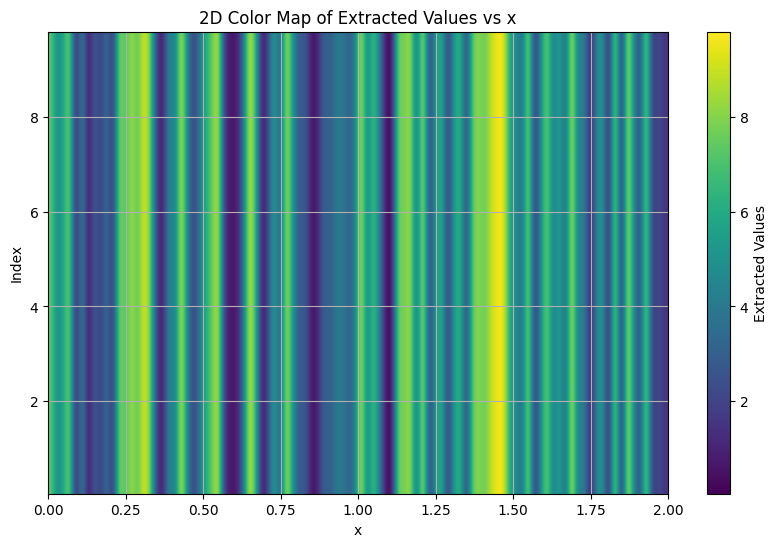

100
100


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example data (replace with your actual data)
x_values = np.linspace(0, 2, 100)  # Example x values
extracted_values_1001 = np.random.rand(100) * 10  # Example extracted values (scaled for visualization)

# Reshape extracted_values_1001 to be a column vector (needed for imshow)
extracted_values_1001 = extracted_values_1001[:, np.newaxis]

# Plotting the 2D color map with smooth gradient
plt.figure(figsize=(10, 6))
plt.imshow(extracted_values_1001.T, extent=[np.min(x_values), np.max(x_values), np.min(extracted_values_1001), np.max(extracted_values_1001)], aspect='auto', cmap='viridis', interpolation='bicubic')
plt.colorbar(label='Extracted Values')
plt.title('2D Color Map of Extracted Values vs x')
plt.xlabel('x')
plt.ylabel('Index')
plt.grid(True)
plt.show()

# Print lengths for debugging
print(len(x_values))
print(len(extracted_values_1001))


In [ ]:
extracted_values_1001 = [value[0].item() for value in total_cost1][::2]

TypeError: 'numpy.float64' object is not iterable

In [ ]:



num_qubits = 6
dev = qml.device("default.qubit", wires=num_qubits)
@qml.qnode(dev)
def variational_circuit1(params, num_layers, variable_values):

    # feature maps
    for i, value in enumerate(variable_values):
        qml.RY(2 * np.arccos(np.clip(value, -1, 1)), wires=i)

    # paramterized variational circuits
    for layer in range(num_layers):
        for i in range(len(variable_values)):
            qml.RZ(params[layer, i, 0], wires=i)
            qml.RX(params[layer, i, 1], wires=i)
        for i in range(len(variable_values) - 1):
            qml.CNOT(wires=[i, i + 1])

    
    return [qml.expval(qml.PauliZ(i)) for i in range(len(variable_values))]
global fn_values        
# Function to calculate the cost fucntion
def cost_fn1(params, num_layers, variable_values):
    fn_values =[] 
    total_cost = 0
    num_iterations = variable_values.shape[1] if len(variable_values.shape) > 1 else variable_values.shape[0]
    for i in range(num_iterations):
        selected_values = variable_values[:, i] if len(variable_values.shape) > 1 else variable_values
        outputs = variational_circuit1(params, num_layers, selected_values)
        fn_values.append(outputs)
        # print(outputs,'      ',selected_values)
        cost = np.sum(outputs)
        total_cost += cost
    return total_cost

num_layers = 4
params = np.full((num_layers, num_qubits, 2), 0.10861666144252709)

# To choose variables to encode
chosen_variables = input(f"Choose the variables to encode from the list {variable_names} (comma-separated): ")
chosen_variables = [v.strip() for v in chosen_variables.split(',')]
selected_values = np.concatenate([variable_values[v] for v in chosen_variables], axis=0)

# To reshape
selected_values = selected_values.reshape(1, -1)
total_cost1 = cost_fn1(params, num_layers, selected_values)
print(f"Total cost = {total_cost1}")
# print(params)


Total cost = -529.1261937325775


In [ ]:
shift = 3.14
derivatives1 = compute_derivatives_for_variables(cost_fn1, variable_names, variable_values, shift, num_layers, params)
print(derivatives1)
# The first value is the variable, then the order of differentiation, and final value is the derivative

[('t', 1, 0.0), ('t', 2, 0.0), ('x', 1, 0.0), ('x', 2, 0.0)]
